##### $Name:\,\color{blue}{Christopher\,J.\,Watson\,,Jessica\,Robledo\,,Paul\,Thai}$
##### $School:\,\color{blue}{Marcos\,School\,of\,Engineering,\,University\,of\,San\,Diego}$
##### $Class:\,\color{blue}{AAI\,510-\,Machine\,Learning\,Fundamentals}$
##### $Assignment:\,\color{blue}{MSAAI\,Final\,Project}$
##### $Date:\,\color{blue}{6/20/2023}$

In [39]:

# Import Libraries
# Basic
import pandas as pd
import numpy as np

# Visualizations
import seaborn as sns
import matplotlib.pyplot as plt 
%matplotlib inline

# Imputation
from sklearn.impute import SimpleImputer

# Metrics
from sklearn import metrics

# Data Processing
from sklearn import preprocessing

# Testing set
from sklearn.model_selection import train_test_split

# Classifier model libraries
from sklearn.ensemble import RandomForestClassifier


In [33]:
# Read In Data Sets
df_1 = pd.read_csv('./Home_Credit/application_train.csv')

### Data Cleaning

The data first needs to be cleaned and prepared for an efficient model to be generated.

In [34]:
# Peek at meta information from the dataset
df_1.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Data columns (total 122 columns):
 #    Column                        Dtype  
---   ------                        -----  
 0    SK_ID_CURR                    int64  
 1    TARGET                        int64  
 2    NAME_CONTRACT_TYPE            object 
 3    CODE_GENDER                   object 
 4    FLAG_OWN_CAR                  object 
 5    FLAG_OWN_REALTY               object 
 6    CNT_CHILDREN                  int64  
 7    AMT_INCOME_TOTAL              float64
 8    AMT_CREDIT                    float64
 9    AMT_ANNUITY                   float64
 10   AMT_GOODS_PRICE               float64
 11   NAME_TYPE_SUITE               object 
 12   NAME_INCOME_TYPE              object 
 13   NAME_EDUCATION_TYPE           object 
 14   NAME_FAMILY_STATUS            object 
 15   NAME_HOUSING_TYPE             object 
 16   REGION_POPULATION_RELATIVE    float64
 17   DAYS_BIRTH                    int64  
 18   DA

As there is a significant amount of data we will need a thorough amount of data preprocessing and cleaning. For that we will create some helper functions to ensure code maintainability.

In [35]:
# Helper Function definitions

# Remove non-unique column data
def col_uniques(X):
    num_unique = X.nunique()
    blank_uniform_cols = num_unique == 1
    X_tmp = X.drop(blank_uniform_cols[blank_uniform_cols].index, axis=1)
    # Print the remaining columns

    return X_tmp

# Gets the Outliers as an array
def get_outliers(X, zthresh,num_col):
    # Get Z Scores
    z_scores = (X[num_col] - X[num_col].mean()) / X[num_col].std()
    
    # Apply and get outliers
    outliers_z = (z_scores > zthresh).any(axis=1)

    Q1 = X[num_col].quantile(0.03)
    Q3 = X[num_col].quantile(0.97)
    IQR = Q3 - Q1
    outliers_iqr = ((X[num_col] < (Q1 - 1.5 * IQR)) | (X[num_col] > (Q3 + 1.5 * IQR))).any(axis=1)
    outliers_combined = outliers_z | outliers_iqr
    
    return outliers_combined

# This function takes a data frame and gives missing column information
def show_pc_miss(df):
    # Create temp arrays
    col_names = []
    perc_missing = []
    
    # Create a column and percentage listing
    for item in df.columns:
        col_names.append(item)
        perc_missing.append(round((df[item].isna().sum() / len(df[item])) * 100, 2))

    # Create a dataframe with columns and percentage missing
    output = pd.DataFrame({
        'col_names': col_names, 
        'perc_missing': perc_missing
    })    
        
    return output

# This function thresholds missing row information and removes those rows
def thres_row(df, thresh_perc):
    # Row Thresholding
    df_res = df.dropna(axis=0, thresh=(df.shape[1] - thresh_perc))
    
    return df_res

# Imputes the data to relieve missing information
def impute_all_data(X, cat_cols, num_cols):
    # create working copy
    df_res = X.copy()
    
    # ImputeNumeric
    mean_puter = SimpleImputer(strategy='mean')
    df_res[num_cols] = mean_puter.fit_transform(df_res[num_cols])

    # ImputeCategories
    freqs_puter = SimpleImputer(strategy='most_frequent')
    df_res[cat_cols] = freqs_puter.fit_transform(df_res[cat_cols])
    
    return df_res
    
# Encode all label data for category columns
def encode_data(df, cat_cols):
    # This is to encode each category into a numeric form
    label_encoder = preprocessing.LabelEncoder()
    
    # create working copy
    df_res = df.copy()

    for col in cat_cols:
        df_res[col] = label_encoder.fit_transform(df_res[col])
    
    return df_res



Then we will create a final bridge function that will maintain the calls for the helper functions so that it is easily used on any new data we might want to pre-process

In [36]:
# It is normally not advised but because in previous assignments we have done the exploration let's data clean all at once with a function we make here.
def clean_all(X, y, drop_thresh):
    
    ### Make temp copies ###
    
    tmp_X = X.copy()
    tmp_y = y.copy()
    
    ### Begin with getting rid of unreasonable incomplete data ###
    
    
    # This gets rid of non-uniquely identified columns
    tmp_X = col_uniques(X)


    # Find columns to drop
    df_missing_cols = show_pc_miss(tmp_X)
    drop_cols = df_missing_cols[df_missing_cols.perc_missing>drop_thresh]
    ##DebugStatements
    print("Columns to drop with criteria of ", drop_thresh ,"%")
    print(drop_cols)
    
    # Drop Columns
    tmp_X = tmp_X.drop(columns=drop_cols['col_names'])
    
    # Drop Rows
    tmp_X = thres_row(tmp_X, drop_thresh)
        
    # Gather new row data
    cat_cols = tmp_X.select_dtypes(exclude=['number']).columns
    num_cols = tmp_X.select_dtypes(include=['number']).columns

    ### Remove outliers ###
    
    # select with a larger zscore than 3
    tmp_outliers = get_outliers(tmp_X,3,num_cols)
    tmp_X = tmp_X[~tmp_outliers]
    
    ### Impute remaining data
    
    tmp_X = impute_all_data(tmp_X, cat_cols, num_cols)
    
    ### Encode categorical data ####
    
    tmp_X = encode_data(tmp_X, cat_cols)
    
    ### Match X and y ####
    
    tmp_y=tmp_y[tmp_X.index]
    
    # Recombine to remove missing target data
    df_res = tmp_X
    df_res["TARGET"] = tmp_y
    
    # Remove missing target data
    df_res = df_res.dropna()
    
    return df_res

Create a new target column from 'NAME_CONTRACT_STATUS' column in Previous_application.csv

In [37]:
# Create X and y values based on ... 
X = df_1.drop(columns=['TARGET', 'SK_ID_CURR'])
y = df_1['TARGET']

#### Cleaning Steps

1) Copy the data to ensure integrity of the old structure
2) Remove non-uniquely identified columns
3) Threshold out columns with 50% missing data or more
4) Remove rows with more than 50% missing data or more
5) We separate out numerical and categorical columns
6) Remove large numerical outliers
7) Mitigate missing data by imputation based on categorical vs numerical data
8) Encode all categorical data
9) Ensure that X and Y are matched in rows
10) Recombine all data into a single frame to ensure compatibility 
11) Drop all rows with missing target data

In [38]:
working_df = clean_all(X, y, 50)
working_df.head(5)

Columns to drop with criteria of  50 %
                   col_names  perc_missing
19               OWN_CAR_AGE         65.99
39              EXT_SOURCE_1         56.38
42            APARTMENTS_AVG         50.75
43          BASEMENTAREA_AVG         58.52
45           YEARS_BUILD_AVG         66.50
46            COMMONAREA_AVG         69.87
47             ELEVATORS_AVG         53.30
48             ENTRANCES_AVG         50.35
50             FLOORSMIN_AVG         67.85
51              LANDAREA_AVG         59.38
52      LIVINGAPARTMENTS_AVG         68.35
53            LIVINGAREA_AVG         50.19
54   NONLIVINGAPARTMENTS_AVG         69.43
55         NONLIVINGAREA_AVG         55.18
56           APARTMENTS_MODE         50.75
57         BASEMENTAREA_MODE         58.52
59          YEARS_BUILD_MODE         66.50
60           COMMONAREA_MODE         69.87
61            ELEVATORS_MODE         53.30
62            ENTRANCES_MODE         50.35
64            FLOORSMIN_MODE         67.85
65             

,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,...,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,TARGET
1,0,0,0,0,0.0,270000.0,1293502.5,35698.5,1129500.0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0
2,1,1,1,1,0.0,67500.0,135000.0,6750.0,135000.0,6,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0
3,0,0,0,1,0.0,135000.0,312682.5,29686.5,297000.0,6,...,0.0,0.0,0.0,0.0,0.0,0.0,0.186701,0.236791,1.832056,0
5,0,1,0,1,0.0,99000.0,490495.5,27517.5,454500.0,5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,1.000000,1.000000,0
7,0,1,1,1,0.0,360000.0,1530000.0,42075.0,1530000.0,6,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0


In [30]:
# Split out new data into X and y for training purposes
X = working_df.drop(columns=['TARGET'])
y = working_df['TARGET']

# Split data further into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [49]:
len(X)

307511

#### Data Modeling

We have successfully cleaned our data to a workable standard so now we can attempt to start creating models

The first model we will work with will be the Random Forest Classifier. This will give us good information about the top data features as well as and idea if our data is sufficient to train a somewhat accurate model. We will first do this by testing the model over a number of estimators to see what would work the best for our model.

In [40]:
# Create Model
model = RandomForestClassifier()

In [41]:
# Try different numbers of n_estimators - 100 to 600
estimators = np.arange(100, 600, 50)
scores = []
for n in estimators:
    model.set_params(n_estimators=n)
    model.fit(X_train, y_train)
    scores.append(model.score(X_test, y_test))
print(scores)   

[0.9179517537368654, 0.9179221548024271, 0.9178925558679888, 0.9179221548024271, 0.9178925558679888, 0.9179221548024271, 0.9178925558679888, 0.9178925558679888, 0.9179517537368654, 0.9178925558679888]


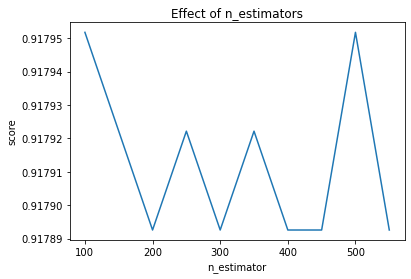

In [42]:
# This graph will let us see the effect of the estimators
plt.title("Effect of n_estimators")
plt.xlabel("n_estimator")
plt.ylabel("score")
plt.plot(estimators, scores)

This is our conclusion of random forest bs need results DO NOT LET ME FORGET TO UPDATE THIS PLEASE

In [43]:
# Create Model
rf = RandomForestClassifier(n_estimators=500, n_jobs=-3, random_state=42)
rf.fit(X_train, y_train)
y_hat = rf.predict(X_train) # Predict the response for train dataset
y_pred = rf.predict(X_test) # Predict the response for test dataset

Now we are going to create some helper functions that will allow us to view the results more readily.

In [44]:
# Creating function that handles the fitting na predictions
def model_fit_pred(cls, X_train, y_train,top_features):
    # Fitting the model first before predictions
    cls = cls.fit(X_train[top_features],y_train)

    # Predicting the response from the dataset
    y_head = cls.predict(X_train[top_features])
    y_pred = cls.predict(X_test[top_features])

    # Return the classifier, y_head, and then the y_pred
    return cls, y_head, y_pred


# Outputting the train/test accuracy and F1 Score
def model_results(y_train, y_test, y_head, y_pred):
    # Finding the F1 score
    f1 = metrics.f1_score(y_pred, y_test, average='weighted')

    # Display the Train/Test Accuracy and then the F1 score
    print("Train Accuracy; ", metrics.accuracy_score(y_train, y_head))
    print("Test Accuracy: ", metrics.accuracy_score(y_test,y_pred))
    print("F1 Score: ", f1)


# Creating a Confusion Matrix for the Models
def model_CM(y_test, y_pred,title_name):
    # Creating the Confusion Matrix
    confusion_matrix = metrics.confusion_matrix(y_test,y_pred)
    
    # Plotting the Confusion Matrix
    metrics.ConfusionMatrixDisplay(confusion_matrix=confusion_matrix).plot()

    # Adding the the title of the plot
    plt.title(title_name)
    plt.show()



Train Accuracy;  1.0
Test Accuracy:  0.9179221548024271
F1 Score:  0.9571185553112974


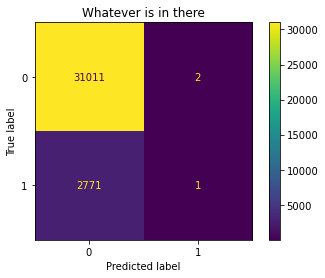

In [45]:
# Print out a nicely formatted results table
model_results(y_train, y_test, y_hat, y_pred)

# Create the confusion table
model_CM(y_test, y_pred,"Whatever is in there")